# Cross Validation
## With and without cross_val_score()
The purpose of this notebook is to demonstrate what cross_val_score() does behind the scenes, and to be able to emulate it when you want predictions from each fold.

The [King County housing price dataset](https://www.kaggle.com/harlfoxem/housesalesprediction/data) from Kaggle will be used.

### Common Imports and Notebook Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
%matplotlib inline
sns.set() # enable seaborn style

In [2]:
# read king county housing data
parser = lambda date: pd.datetime.strptime(date, '%Y%m%dT%H%M%S')
all_data = pd.read_csv('./data/kc_house_data.csv', parse_dates=['date'], date_parser=parser)
all_data.shape

(21613, 21)

## EDA for King County Housing Data

In [3]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null datetime64[ns]
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(15)
memory usage: 3.5 MB


From above:
* no missing values
* no variables of type 'object'

In [4]:
# min and max dates
print(all_data['date'].min())
print(all_data['date'].max())

2014-05-02 00:00:00
2015-05-27 00:00:00


There is just over 1 year's worth of data.

Let's look at the moving average of price.

In [5]:
# set the index to date and sort it
tmp = all_data.copy()
tmp = tmp.set_index('date').sort_index()

# get the average sales price per day
tmp = tmp['price'].resample('D').mean()

# fill days with no sales, with the previous day's value
tmp = tmp.fillna(method='ffill')

# create a 10 day rolling mean of prices
prices_moving_avg = tmp.rolling(10).mean()

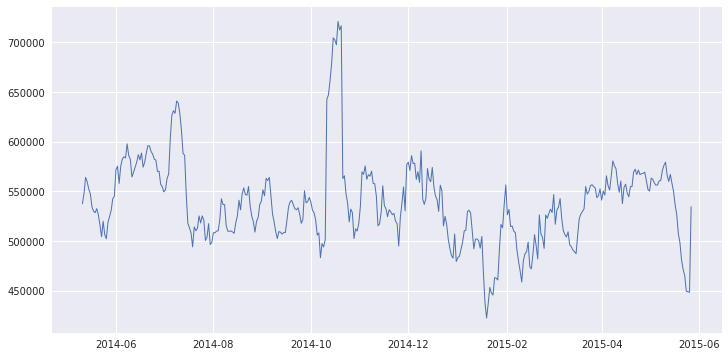

In [6]:
plt.figure(figsize=(12,6))
plt.plot(prices_moving_avg, linewidth=1)

There is no obvious seasonal or linear price trend.  Let's ignore date for this analysis.

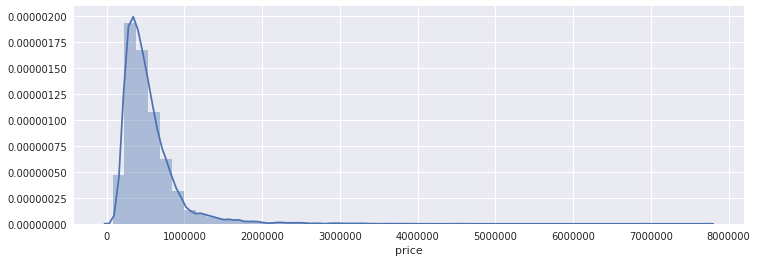

In [7]:
# avoid incorrect userwarning in this version of anaconda
import warnings
warnings.simplefilter("ignore", UserWarning)

plt.figure(figsize=(12,4))
sns.distplot(all_data['price'])

We see the prices are heavily right skewed.  Some models, such as linear regression, expect the target variable (but not the input variables) be normally distributed.  In that case, a log transform of the target would likely be helpful.  That won't be necessary for the models used in this notebook.

In the density plot above, wherever the density is low, there are few sales of houses near that price.  With few examples of sales in a given price range, most models will not be able to predict well in that price range.  Rather than try to come up with a model that works over the entire range of observed prices, let's remove the top and bottom 10% of the values.

An alternative way of thinking about this is, the loss function is zero for extreme house prices.  This allows for the best model fit to the middle 80% of the data.

The caveat with this approach is that the resulting model should not be used for very low or very high prices houses.

In [8]:
# Keep middle 80% by price
price = all_data['price']
low, high = price.quantile([0.1, 0.9])
print(f'Model Limits for Price: low={low: .0f} high={high: .0f}')
price_filter = (price >= low) & (price <= high)
data = all_data[price_filter]

Model Limits for Price: low= 245000 high= 887000


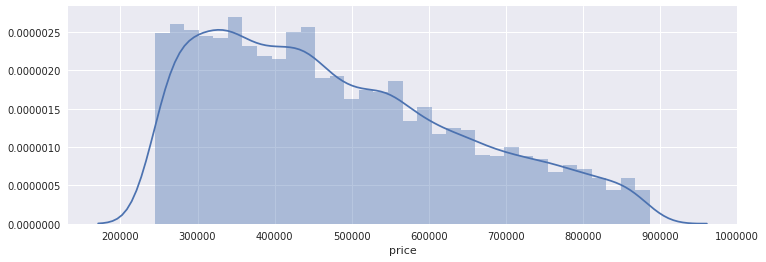

In [9]:
# view the filtered price values
plt.figure(figsize=(12,4))
sns.distplot(data['price'])

In [10]:
# Examine the id field
print(f'Num Unique ids: {all_data["id"].nunique()}')
print(f'Num Records:    {all_data["id"].count()}')

Num Unique ids: 21436
Num Records:    21613


Not all the ids are unique.  Let's examine a few of the records having duplicate ids.

In [11]:
data.groupby(['id']).filter(lambda x: len(x) > 1).head(4)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
93,6021501535,2014-07-25,430000.0,3,1.50,1580,5000,1.0,0,0,...,8,1290,290,1939,0,98117,47.6870,-122.386,1570,4500
94,6021501535,2014-12-23,700000.0,3,1.50,1580,5000,1.0,0,0,...,8,1290,290,1939,0,98117,47.6870,-122.386,1570,4500
371,2231500030,2014-10-01,315000.0,4,2.25,2180,10754,1.0,0,0,...,7,1100,1080,1954,0,98133,47.7711,-122.341,1810,6929
372,2231500030,2015-03-24,530000.0,4,2.25,2180,10754,1.0,0,0,...,7,1100,1080,1954,0,98133,47.7711,-122.341,1810,6929


We see two dates and two prices, for each of the above duplicate ids and the rest of the data is the same.  This suggests that each record in the dataset represents a sale, however we are interested in the price of a house.

Let's replace sale price with the average sale price per house.  This will create duplicate records.  Remove these duplicates and now we have a dataframe of houses with one house price for each.

In [12]:
# compute mean price per id
mean_price_by_id = data.groupby(['id'])['price'].mean()

# convert this to a data frame
mean_price_by_id = pd.DataFrame(mean_price_by_id)

# join on id to get a new column for mean price
data = data.merge(right=mean_price_by_id, on='id', suffixes=['_orig', '_mean'])

In [13]:
# look at 2 house ids to verify above code
data[data['id'].isin([6021501535, 2231500030])]

,id,date,price_orig,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_mean
69,6021501535,2014-07-25,430000.0,3,1.50,1580,5000,1.0,0,0,...,1290,290,1939,0,98117,47.6870,-122.386,1570,4500,565000.0
70,6021501535,2014-12-23,700000.0,3,1.50,1580,5000,1.0,0,0,...,1290,290,1939,0,98117,47.6870,-122.386,1570,4500,565000.0
290,2231500030,2014-10-01,315000.0,4,2.25,2180,10754,1.0,0,0,...,1100,1080,1954,0,98133,47.7711,-122.341,1810,6929,422500.0
291,2231500030,2015-03-24,530000.0,4,2.25,2180,10754,1.0,0,0,...,1100,1080,1954,0,98133,47.7711,-122.341,1810,6929,422500.0


In [14]:
# drop records with duplicate ids
data = data.drop_duplicates(subset='id', keep='last')

# drop the original price
data = data.drop('price_orig', axis=1)

# look at 2 house ids to verify above code
data[data['id'].isin([6021501535, 2231500030])]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_mean
70,6021501535,2014-12-23,3,1.50,1580,5000,1.0,0,0,3,...,1290,290,1939,0,98117,47.6870,-122.386,1570,4500,565000.0
291,2231500030,2015-03-24,4,2.25,2180,10754,1.0,0,0,5,...,1100,1080,1954,0,98133,47.7711,-122.341,1810,6929,422500.0


There is now one record per house with a single price.  The date refers to the last sale date, but date will not be used in this analysis.

In [15]:
# drop id and price_orig
data = data.drop(['id', 'date'], axis=1)

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17281 entries, 0 to 17370
Data columns (total 19 columns):
bedrooms         17281 non-null int64
bathrooms        17281 non-null float64
sqft_living      17281 non-null int64
sqft_lot         17281 non-null int64
floors           17281 non-null float64
waterfront       17281 non-null int64
view             17281 non-null int64
condition        17281 non-null int64
grade            17281 non-null int64
sqft_above       17281 non-null int64
sqft_basement    17281 non-null int64
yr_built         17281 non-null int64
yr_renovated     17281 non-null int64
zipcode          17281 non-null int64
lat              17281 non-null float64
long             17281 non-null float64
sqft_living15    17281 non-null int64
sqft_lot15       17281 non-null int64
price_mean       17281 non-null float64
dtypes: float64(5), int64(14)
memory usage: 2.6 MB


Examine yr_built and yr_renovated

In [17]:
all_data[['yr_built','yr_renovated']].head(3)

,yr_built,yr_renovated
0,1955,0
1,1951,1991
2,1933,0


Replace yr_built with yr_renovated if yr_renovated is not 0.

In [18]:
# repace yr_built with yr_renovated if yr_renovated != 0
mask = data['yr_renovated'] != 0
data.loc[mask, 'yr_built'] = data.loc[mask, 'yr_renovated']
data = data.drop('yr_renovated',axis=1)

Examine zipcode

In [19]:
data['zipcode'].nunique()

70

There are 70 unique values. This is probably too many to one hot encode.

Much of the information in zip code may be contained in latitude and longitude.  No doubt there is additional valuable information in zip code, but for this notebook, it will be dropped.

In [20]:
data = data.drop(['zipcode'], axis=1)

There are other categorical variables, such as waterfront, view, condition, grade, etc., but these seem to be ordered categorical variables encoded as integers, so leave them as is.

In [21]:
data.head(3)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,lat,long,sqft_living15,sqft_lot15,price_mean
0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1991,47.7210,-122.319,1690,7639,538000.0
1,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,47.5208,-122.393,1360,5000,604000.0
2,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,47.6168,-122.045,1800,7503,510000.0


Although feature extraction will not be done here, it is worth noting some subtle ways in which feature engineering can inadvertently cause data leakage.

Let's say you wanted to create a feature that represented the median sale price of the n nearest houses.  Clearly this feature could not include the price of the house you are trying to predict, as that would leak test data into the training data.

More subtly, houses are sold at a particular point in time.  It is impossible to know the future sales price of the houses near the house under consideration.  One correct definition of the new feature would be: the median sale price of the n closest houses which sold on or before the date of the house record currently being processed.

Let's move on to building a model.

In [22]:
# create target vector and feature matrix
X = data.drop('price_mean', axis=1).values
y = data['price_mean'].values
print(X.shape)
print(y.shape)

(17281, 16)
(17281,)


## Model Building
It seems reasonable that similar houses would have similar prices, so let's try a simple KNN model.

KNN suffers from the "curse of dimensionality" and therefore dimensionality reduction must be used.  PCA is one method.  Here I will use an ExtraTreesClassifier to find the "most important" variables and only use these.

Feature Selection is perhaps the most common way in which data leakage accidentally occurs when creating a model.  Whatever technique is used to select features, must be part of the pipeline within cross-validation to avoid data leakage.

Fortunately Scikit Learn has a meta-estimator designed to make this process easy.

KNN assumes each dimension along which the distance is calculated is weighted the same.  This means that the feature matrix must be standardized prior to creating the KNN model so that each variable is given the same weight in the distance calculation.

The pipeline is:
* build an ExtraTreesRegressor
* select all features that are as least as good as the median importance score
* using this subset of features, standardize them so they have unit variance and zero mean
* build a KNN model

### Cross Validation using Pipeline with cross_value_score

In [23]:
# create the feature selector
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
etree = ExtraTreesRegressor(n_jobs=-1, random_state=10000)
selector = SelectFromModel(etree, threshold='median')

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
scale = StandardScaler()
knn = KNeighborsRegressor(n_neighbors=10, weights='distance')

pipe = Pipeline(steps=[('selector', selector), ('scale', scale), ('knn',knn)])

# setup an explict cv generator for repeatability
k_folds = 10
random_seed=108
cv = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

In [25]:
# compute the cross validated scores for this pipeline
scores = cross_val_score(pipe, X, y, cv=cv, n_jobs=-1, 
                    scoring='neg_mean_absolute_error')
mad = -scores.mean()
mad

55793.15726008088

### Cross Validation without Pipeline or cross_value_score
The following produces exactly the same result as above.  It takes many more lines of code, but it is instructive for understanding how cross_value_score is using the pipeline behind the scenes and demonstrates how to access the test prediction for each fold.

In [26]:
# replace cross_val_score with the following for-loop, no pipeline
from sklearn.metrics import mean_absolute_error
my_scores = []
for train_idx, test_idx in cv.split(X):
    
    # train
    X_train = X[train_idx, :]
    y_train = y[train_idx]
    
    X_train_reduced = selector.fit_transform(X_train, y_train)
    X_train_transformed = scale.fit_transform(X_train_reduced)
    
    # test
    X_test = X[test_idx, :]
    y_test = y[test_idx]
    
    X_test_reduced = selector.transform(X_test)
    X_test_transformed = scale.transform(X_test_reduced)

    # fit model on train
    knn.fit(X_train_transformed, y_train)
    
    # predict on test
    predictions = knn.predict(X_test_transformed)
    
    # evaluate accuracy
    score = mean_absolute_error(y_test, predictions)
    my_scores.append(score)

# print results
mad2 = np.mean(my_scores)
print(mad == mad2)

True


The above code produces exactly the same result as the more concise code that used a pipeline and cross_val_score().

Note that normally np.isclose() should be preferred with floating point values to '==' as two floating point values within epsilon of each other are the same.  Here I used '==' to emphasize that the code above is indeed extremely close to what cross_val_score() is doing behind the scenes.

True


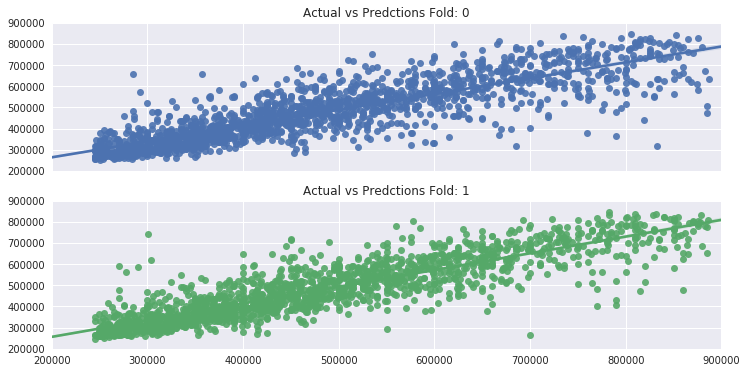

In [27]:
# same as above, but with pipeline for preprocessing
pipe = Pipeline(steps=[('selector', selector), ('scale', scale)])

my_scores = []
fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True, sharey=True)
for i, (train_idx, test_idx) in enumerate(cv.split(X)):
    
    # train
    X_train = X[train_idx, :]
    y_train = y[train_idx]
    
    X_train_std_pca = pipe.fit_transform(X_train, y_train)
    
    # test
    X_test = X[test_idx, :]
    y_test = y[test_idx]
    
    X_test_std_pca = pipe.transform(X_test)

    # fit model on train
    knn.fit(X_train_std_pca, y_train)
    
    # predict on test
    predictions = knn.predict(X_test_std_pca)
    
    # evaluate accuracy
    my_scores.append(mean_absolute_error(y_test, predictions))
    
    # plot a couple fold results
    if i < 2:
        #ax = axes[i//2, i%2]
        ax = axes[i]
        ax.set(xlim=((200000,900000)), ylim=((200000,900000)))
        ax.set_title(f'Actual vs Predctions Fold: {i}')
        sns.regplot(y_test, predictions, scatter_kws={'alpha':0.9}, ax=ax)    
        # sns.regplot(x=np.array([200000,900000]), y=np.array([200000,900000]), color='blue', ax=ax)
        # sns.regplot(y = y_test-predictions, x = y_test, scatter_kws={'alpha':0.6}, ax=ax)

# print results
mad3 = -scores.mean()
print(mad == mad3)